In [29]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.utils.data
import torch.distributions
from PIL import Image
from texture_vae.models.texture_vae import Autoencoder
import texture_vae.utils.texture_dataset as dataset
from torchsummary import summary
import os
import torchvision
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from  torch.optim.lr_scheduler import CyclicLR
%matplotlib inline
import time
from IPython import display

# Constants

In [30]:
TEXTURE_SIZE = 128
BATCH_SIZE = 64
LATENT_DIMS = 64
DEVICE="cpu"

# Texture VAE Details

Excellent reading on VAEs 
https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368

## Model Loading

Load the model, its weights and setup Dataloader

In [31]:
def load_model(snapshot_fn:str, latent_dims: int, texture_size:int):
    autoencoder = Autoencoder(latent_dims=latent_dims, image_size=texture_size, device=DEVICE)
    autoencoder.load_state_dict(torch.load(snapshot_fn))
    return autoencoder

## Plot Samples from normal distribution

In [32]:
def show_samples(sampled_images, dpi=150):
    plt.rcParams["savefig.bbox"] = 'tight'
    plt.rcParams['figure.dpi'] = dpi
    plt.axis('off')
    from torchvision.utils import make_grid
    import torchvision.transforms.functional as F
    grid = make_grid(sampled_images)
    grid = F.to_pil_image(grid)
    plt.imshow(grid)
    plt.show()

In [33]:

def sample_around(latent, num_samples: int):
    with torch.inference_mode():
        seed_image = ae.sample(latent)
        x_rec, mu, logvar,_ = ae(seed_image)
        z = latent + torch.normal(mu.repeat(num_samples,1), torch.exp(logvar).repeat(num_samples,1))
        print(z)
        return ae.sample(z + 0.5*torch.randn(4,16))

    
    
    

In [47]:
ae = load_model("../snapshots/snapshot_lat64_res128_kl0.7.pth", texture_size=TEXTURE_SIZE, latent_dims=LATENT_DIMS)




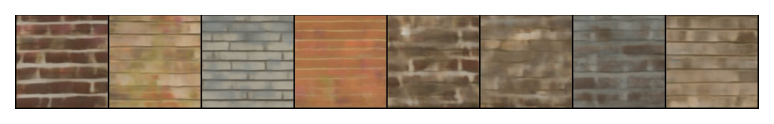

In [48]:
sample_seed = torch.normal(0, 1, (8,ae.latent_dims)).to(ae.device)
sampled_images = ae.sample(sample_seed)
show_samples(sampled_images, 150)

In [49]:
def create_texture(target_width:int, target_height:int, seed_patch: torch.Tensor):
    stitch_result = torch.zeros((3, target_height,target_width))
    overlap = 16
    patch_size =  ae.image_size
    with torch.no_grad():
        stitch_result[:,:patch_size,:patch_size] = seed_patch
    return stitch_result



In [50]:
# with torch.no_grad():
#     #print(sampled_images.shape)
#     x_hat, mu, logvar, z = ae(sampled_images[0].unsqueeze(dim=0))
#     rec_images = ae.sample(z.unsqueeze(dim=0))
#     show_samples(rec_images, 50)

# plt.rcParams['figure.dpi'] = 100
# tex = create_texture( target_width=128*3, target_height=128, seed_patch=sampled_images[2])
# img = F.to_pil_image(tex)
# plt.imshow(img)
# plt.show()



In [51]:
def _get_overlay_mask(patch: torch.Tensor, overlap:int, target_x:int, target_y:int):
    patch_mask = torch.zeros_like(patch, dtype=torch.int)
    if target_x > 0:
       patch_mask[:,:,:overlap] = 1
    if target_y > 0:
       patch_mask[:,:overlap,:] = 1
    return  patch_mask

def _get_blend_mask(patch: torch.Tensor, overlap:int, target_x:int, target_y:int):
    blend_mask = torch.ones_like(patch, dtype=torch.float)
    if target_x > 0:
        blend_mask[:,:,:overlap] = blend_mask[:,:,:overlap]*torch.linspace(0,1,overlap)
    if target_y > 0:
        factor = torch.linspace(0,1,overlap).repeat(blend_mask.shape[1],1).transpose(0,1)
        blend_mask[:, :overlap, :] = blend_mask[:, :overlap, :] * factor
    return  blend_mask

def stich(ae: Autoencoder, epochs:int, texture:torch.Tensor, overlap:int, target_x:int, target_y:int,start_z):
    if z is None:
        seed_latent = torch.zeros(1,ae.latent_dims).to(ae.device)
    else:
        seed_latent = start_z
    patch_latents = nn.Parameter(seed_latent, requires_grad=True)
    opt = torch.optim.Adam(params=[patch_latents], lr=1e-1)
    scheduler = CyclicLR(opt, base_lr=1e-1, max_lr=1e0, step_size_up=epochs//4, cycle_momentum=False)
    with tqdm(range(epochs), total=epochs) as tepoch:
        for e in tepoch:
            opt.zero_grad()
            patch = ae.decoder(patch_latents)[0]
            mask = _get_overlay_mask(patch, overlap, target_x, target_y)
            # print(overlap_patch.shape)
            # overlap_patch = patch[m]
            # print(overlap_patch.shape)
            target_patch = texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]]
            # print(overlap_texture.shape)
            # if e == 0:
            #     img = F.to_pil_image(target_patch*mask)
            #     plt.imshow(img)
            #     plt.show()
            # if e == 0:
            #     img = F.to_pil_image(patch*mask)
            #     plt.imshow(img)
            #     plt.show()
            mse = torch.sum((target_patch*mask - patch*mask) ** 2)
            mse.backward()
            opt.step()
           # scheduler.step()
            tepoch.set_postfix(loss=mse.item())
    target_patch = texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]]
    blend_mask = _get_blend_mask(patch, overlap, target_x, target_y)
    texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]] = (1-blend_mask)*target_patch +  blend_mask*patch
    return texture.detach(), patch_latents.detach()
    

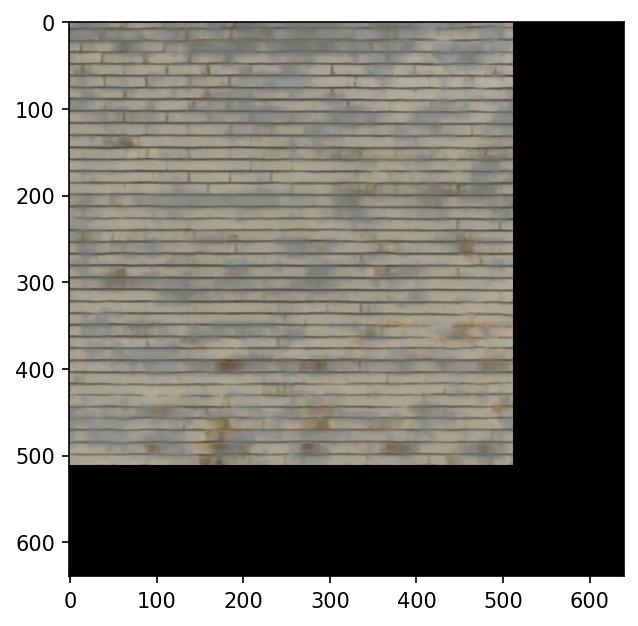

In [53]:
plt.rcParams['figure.dpi'] = 150
tex = create_texture( target_width=128*5, target_height=128*5, seed_patch=sampled_images[2])
img = F.to_pil_image(tex)
plt.imshow(img)
plt.show()
stitch_result = tex.clone()
overlap=32
with torch.no_grad():
    x_hat, mu, logvar, z = ae(sampled_images[0].unsqueeze(dim=0))

for y in range(0,5):
    for x in range(0,5):
        if x ==0 and y==0:
            continue
        stitch_result, _ = stich(ae, epochs=500, texture=stitch_result.detach(), overlap=overlap, target_x=x*ae.image_size-x*overlap, target_y = y*ae.image_size-y*overlap, start_z = z)
        img = F.to_pil_image(stitch_result)
        display.clear_output(wait=True)
        plt.imshow(img)
        plt.show()
# img = F.to_pil_image(stitch_result)
# #img.save(f"stich_final.jpg")
# plt.imshow(img)
# plt.show()    

In [ ]:
torch.linspace(0,1,16)

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333, 1.0000])